# [COM4513-6513] Assignment 1: Text Classification with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test two text classification systems: 

- **Task 1:** sentiment analysis, in particular to predict the sentiment of movie review, i.e. positive or negative (binary classification).
- **Task 2:** topic classification, to predict whether a news article is about International issues, Sports or Business (multiclass classification).


For that purpose, you will implement:

- Text processing methods for extracting Bag-Of-Word features, using (1) unigrams, bigrams and trigrams to obtain vector representations of documents. Two vector weighting schemes should be tested: (1) raw frequencies (**3 marks; 1 for each ngram type**); (2) tf.idf (**1 marks**). 
- Binary Logistic Regression classifiers that will be able to accurately classify movie reviews trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 1. 
- Multiclass Logistic Regression classifiers that will be able to accurately classify news articles trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 2. 
- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function for Task 1 (**3 marks**)
    - Minimise the Categorical Cross-entropy loss function for Task 2 (**3 marks**)
    - Use L2 regularisation (both tasks) (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous validation loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)
- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength)?  (**2 marks; 0.5 for each model in each task**).
- After training the LR models, plot the learning process (i.e. training and validation loss in each epoch) using a line plot (**1 mark; 0.5 for both BOW-count and BOW-tfidf LR models in each task**) and discuss if your model overfits/underfits/is about right.
- Model interpretability by showing the most important features for each class (i.e. most positive/negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!).  If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks; 0.5 for BOW-count and BOW-tfidf LR models respectively in each task**)


### Data - Task 1 

The data you will use for Task 1 are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.

### Data - Task 2

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.


### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc..

Please make sure to comment your code. You should also mention if you've used Windows (not recommended) to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Fri, 20 Mar 2020** and it needs to be submitted via MOLE. Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
data_tr=pd.read_csv('./data_sentiment/train.csv',names=["text","label"])
data_dev = pd.read_csv('./data_sentiment/dev.csv', names=["text","label"])
data_te = pd.read_csv('./data_sentiment/test.csv', names=["text","label"])


If you use Pandas you can see a sample of the data.

In [3]:
data_tr.head()

,text,label
0,note : some may consider portions of the follo...,1
1,note : some may consider portions of the follo...,1
2,every once in a while you see a film that is s...,1
3,"when i was growing up in 1970s , boys in my sc...",1
4,"the muppet movie is the first , and the best m...",1


The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [4]:
# fill in your code...
# put all 3 file into lists and array
X_tr_raw = data_tr['text'].tolist() #DataFrame to python list
Y_tr = data_tr['label'].values # DataFrame to numpy arrays

X_dev_raw = data_dev['text'].tolist()
Y_dev = data_dev['label'].values

X_test_raw = data_te['text'].tolist()
Y_te = data_te['label'].values  

# Bag-of-Words Representation 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (you can keep top N if you encounter memory issues).


In [5]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they' 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.

See the examples below to see how this function should work.

In [6]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    x = []
    # Regular expression
    pattern = re.compile(token_pattern).findall(x_raw.lower())    
    # Get words without stop word
    unigram = [word for word in pattern if word not in stop_words and re.match(token_pattern, word)] 
    # generate 3 types ngrams
    for n in range(ngram_range[0], ngram_range[1]+1):
        if n == 1:
            x.extend(unigram)
        elif n == 2:
            x.extend([(word1, word2) for word1, word2 in zip(unigram[:-1], unigram[1:])])
        elif n == 3:
            x.extend([(word1, word2, word3) for word1, word2, word3 in zip(unigram[:-2], unigram[1:-1], unigram[2:])])
        if len(vocab) != 0:
            x = [w for w in x if w in vocab]        
    return x
    
    # fill in your code...




In [7]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,3), 
               stop_words=stop_words)

['great',
 'movie',
 'watch',
 ('great', 'movie'),
 ('movie', 'watch'),
 ('great', 'movie', 'watch')]

In [8]:
extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,2), 
               stop_words=stop_words, 
               vocab=set(['great',  ('great','movie')]))

['great', ('great', 'movie')]

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [9]:
from collections import Counter

def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):
    grams = []
    for x in X_raw:
          grams.extend(set(extract_ngrams(x, ngram_range, token_pattern, stop_words))) # get n-grams vocabulary list
    df_grams = Counter(grams)
    for key in df_grams.keys(): # if df value is smaller than required value, delete the element
        if df_grams[key] < min_df:
            del df_grams[key]
    # get top N occur times in df
    ngram_counts = df_grams.most_common(keep_topN) 
    # get word in ngram counts
    vocab = set([word[0] for word in ngram_counts])
    
    # fill in your code...
    
    
    return vocab, df_grams, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [10]:
vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

[('might', 'well'), ('not', 'so'), ('few', 'years'), 'cheating', 'ups', 'getting', 'after', 'join', 'ask', 'gross', 'surrounding', ('comic', 'relief'), 'glenn', ('little', 'too'), ('beginning', 'end'), ('after', 'being'), ('know', 'but'), 'drew', 'issues', 'travel', 'path', 'awake', 'president', ('their', 'characters'), 'notice', 'complex', 'built', 'groups', ('both', 'films'), 'plausible', 'entertaining', 'elaborate', 'reputation', 'efforts', ('more', 'more'), ('most', 'notably'), 'really', 'pointless', 'destroy', 'alike', 'hanks', 'remake', 'connected', 'walks', 'fell', 'done', ('one', 'their'), 'room', 'list', ('however', 'when'), 'dedicated', 'progress', 'cards', 'martin', 'special', ('so', 'there'), 'sky', 'ridiculous', 'object', 'section', 'boredom', 'dreams', 'blockbuster', 'miscast', 've', 'appreciated', ('small', 'town'), 'average', 'shannon', 'terrifying', 'contrived', 'beautiful', 'twice', 'hostage', 'allen', 'bringing', ('all', 'too'), 'develops', 'devil', 'slightly',

Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [11]:
# fill in your code...
# generate word and corresponding id
word_id = {}
i = 0
for i, w in enumerate(list(vocab)):
    word_id[w] = i

In [12]:
word_id

{('might', 'well'): 0,
 ('not', 'so'): 1,
 ('few', 'years'): 2,
 'cheating': 3,
 'ups': 4,
 'getting': 5,
 'after': 6,
 'join': 7,
 'ask': 8,
 'gross': 9,
 'surrounding': 10,
 ('comic', 'relief'): 11,
 'glenn': 12,
 ('little', 'too'): 13,
 ('beginning', 'end'): 14,
 ('after', 'being'): 15,
 ('know', 'but'): 16,
 'drew': 17,
 'issues': 18,
 'travel': 19,
 'path': 20,
 'awake': 21,
 'president': 22,
 ('their', 'characters'): 23,
 'notice': 24,
 'complex': 25,
 'built': 26,
 'groups': 27,
 ('both', 'films'): 28,
 'plausible': 29,
 'entertaining': 30,
 'elaborate': 31,
 'reputation': 32,
 'efforts': 33,
 ('more', 'more'): 34,
 ('most', 'notably'): 35,
 'really': 36,
 'pointless': 37,
 'destroy': 38,
 'alike': 39,
 'hanks': 40,
 'remake': 41,
 'connected': 42,
 'walks': 43,
 'fell': 44,
 'done': 45,
 ('one', 'their'): 46,
 'room': 47,
 'list': 48,
 ('however', 'when'): 49,
 'dedicated': 50,
 'progress': 51,
 'cards': 52,
 'martin': 53,
 'special': 54,
 ('so', 'there'): 55,
 'sky': 56,
 'rid

Now you should be able to extract n-grams for each text in the training, development and test sets:

In [13]:
# fill in your code...
X_train_ngram = []
X_dev_ngram = []
X_test_ngram = []

# generate 3 file's ngrams list
for i in X_tr_raw:
    X_train_ngram.append(extract_ngrams(i, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=stop_words, vocab=vocab))
for i in X_dev_raw:
    X_dev_ngram.append(extract_ngrams(i, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=stop_words, vocab=vocab))
for i in X_test_raw:
    X_test_ngram.append(extract_ngrams(i, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=stop_words, vocab=vocab))

In [14]:
#X_train_ngram
#X_dev_ngram
#X_test_ngram

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [15]:
def vectorise(X_ngram, vocab):
    
    # fill in your code...
    X_vec = []
    for i in X_ngram:
        # creater counter object
        counter = Counter(i)
        # create zero lists
        vector = list(0 for j in range(len(vocab)))         
        for j in counter.keys():
            # add number into list correspond to the position
            vector[word_id[j]] = vector[word_id[j]]+ counter[j]
        X_vec.append(vector)
    # change to np array format    
    X_vec = np.array(X_vec)
        
    
    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [16]:
# fill in your code...
X_tr_count = vectorise(X_train_ngram, vocab)
X_dev_count = vectorise(X_dev_ngram, vocab)
X_test_count = vectorise(X_test_ngram, vocab)

In [17]:
X_tr_count.shape

(1400, 5000)

In [18]:
X_tr_count[:2,:50]

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [19]:
idfs = []
for i in list(vocab):
    # set a variable to record occurance times 
    df_count = 0
    # if it occur, variable + 1
    for j in X_train_ngram:
        if i in j:  
            df_count = df_count + 1
    idfs.append(np.log10(X_tr_count.shape[0]/(df_count+1)))
# change to numpy array
idfs = np.array(idfs)
    

Then transform your count vectors to tf.idf vectors:

In [20]:
# fill in your code...
X_tr_tfidf = X_tr_count * idfs
X_dev_tfidf = X_dev_count * idfs
X_test_tfidf = X_test_count * idfs

In [21]:
X_tr_tfidf[1,:50]

array([0.        , 1.27689632, 0.        , 0.        , 2.89431606,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.73115469, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.16840443, 0.        , 1.84509804, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.37675071, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [22]:
def sigmoid(z):    
    # fill in your code...
    z = 1/(z+np.exp(-z))    
    return z

In [23]:
print(sigmoid(0)) 
print(sigmoid(np.array([-5., 1.2])))

1.0
[0.00697286 0.66613633]


Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [24]:
def predict_proba(X, weights):    
    preds_proba = sigmoid(np.matmul(X, weights.T))    
    
    return preds_proba

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [25]:
def predict_class(X, weights):    
    pre_pro = predict_proba(X, weights)
    preds_class = (pre_pro > 0.5)    
    
    return preds_class

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [26]:
def binary_loss(X, Y, weights, alpha=0.00001):

    l = - np.mean(np.reshape(Y,[-1,1]) * np.log(predict_proba(X, weights)) + (1 - np.reshape(Y,[-1,1])) * np.log(1 - predict_proba(X, weights))) + alpha * np.sum(weights**2)

    return l
    

Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [27]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], loss="binary", lr=0.1, alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    
    cur_loss_tr = 1.
    cur_loss_dev = 1.
    training_loss_history = []
    validation_loss_history = []
    
    # fill in your code...
    weights = np.zeros([1, X_tr.shape[1]])
    for i in range(epochs):
        # generate random order of Dtrain
        ran_order = np.random.permutation(X_tr.shape[0])
        for j in ran_order:
            Y_pred = predict_proba(X_tr[j:j+1,:], weights)
            weights = weights - lr * ((Y_pred - Y_tr[j])*X_tr[j:j+1,:] + 2*alpha*weights)
        training_loss_history.append(binary_loss(X_tr, Y_tr, weights, alpha))
        validation_loss_history.append(binary_loss(X_dev, Y_dev, weights, alpha))
        
        if print_progress:
            print('Epoch times: {}, Training loss value: {}, Validation loss value: {}'.format(i, training_loss_history[-1], validation_loss_history[-1]))


        if len(validation_loss_history)>=2 and np.abs(validation_loss_history[-1] - validation_loss_history[-2]) < tolerance:
            break
        
    return weights, training_loss_history, validation_loss_history

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [28]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr, 
                                             X_dev=X_dev_count, 
                                             Y_dev=Y_dev, 
                                             lr=0.0001, 
                                             alpha=0.001, 
                                             epochs=100)

Epoch times: 0, Training loss value: 0.749131362931535, Validation loss value: 0.8046820309458966
Epoch times: 1, Training loss value: 0.6632104780039288, Validation loss value: 0.744169092692292
Epoch times: 2, Training loss value: 0.6012626358432159, Validation loss value: 0.7082495173510467
Epoch times: 3, Training loss value: 0.554256859573442, Validation loss value: 0.6792630611601946
Epoch times: 4, Training loss value: 0.5189381109621553, Validation loss value: 0.6554419213407493
Epoch times: 5, Training loss value: 0.4889336856158846, Validation loss value: 0.640525346232427
Epoch times: 6, Training loss value: 0.4746281930232947, Validation loss value: 0.6270564165245279
Epoch times: 7, Training loss value: 0.44159661547162926, Validation loss value: 0.621170878026744
Epoch times: 8, Training loss value: 0.4233945730531655, Validation loss value: 0.6144345526848554
Epoch times: 9, Training loss value: 0.406143203261203, Validation loss value: 0.6164585710522216
Epoch times: 10

Epoch times: 83, Training loss value: 5.420939657536903, Validation loss value: 5.42196060327926
Epoch times: 84, Training loss value: 5.526238439860503, Validation loss value: 5.52726754846999
Epoch times: 85, Training loss value: 5.633285575024265, Validation loss value: 5.634322514970587
Epoch times: 86, Training loss value: 5.742087994855737, Validation loss value: 5.743132454394313
Epoch times: 87, Training loss value: 5.8526524212219195, Validation loss value: 5.853704106959715
Epoch times: 88, Training loss value: 5.964985216898441, Validation loss value: 5.966043851120231
Epoch times: 89, Training loss value: 6.079092025932584, Validation loss value: 6.080157347956066
Epoch times: 90, Training loss value: 6.1949780933733845, Validation loss value: 6.196049857032463
Epoch times: 91, Training loss value: 6.31264885604994, Validation loss value: 6.313726827387989
Epoch times: 92, Training loss value: 6.432108042273137, Validation loss value: 6.4331920005637455
Epoch times: 93, Tra

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

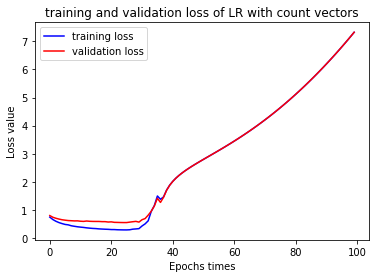

In [29]:
plt.plot(range(len(loss_tr_count)), loss_tr_count, c = 'blue', label='training loss')
plt.plot(range(len(dev_loss_count)), dev_loss_count,c = 'red', label = 'validation loss')
plt.xlabel('Epochs times')
plt.ylabel('Loss value')
plt.legend()
plt.title('training and validation loss of LR with count vectors')
plt.show()

**From the graph above, we can know my model is overfitting, because the training loss is lower than the validation loss.**

Compute accuracy, precision, recall and F1-scores:

In [30]:

preds_te_count = predict_class(X_test_count, w_count)
print('Accuracy:', accuracy_score(Y_te,preds_te_count))
print('Precision:', precision_score(Y_te,preds_te_count))
print('Recall:', recall_score(Y_te,preds_te_count))
print('F1-Score:', f1_score(Y_te,preds_te_count))

Accuracy: 0.5
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


C:\software_program\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\software_program\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Finally, print the top-10 words for the negative and positive class respectively.

In [31]:
# fill in your code...
pre_word = predict_proba(X_test_count, w_count)
index = np.argsort(pre_word,axis = 0)
print('top 10 postive, 1-10')
for i in range(1,11):
    print(X_test_raw[index[-i,0]])
    

top 10 postive, 1-10
9 : its pathetic attempt at " improving " on a shakespeare classic .  8 : its just another piece of teen fluff .  7 : kids in high school are not that witty .  6 : the wittiness is not witty enough .  5 : the comedy is not funny .  4 : the acting is poor .  3 : the music .  2 : the poster .  1 : its worse than she's all that !  10=a classic 9=borderline classic 8=excellent 7=good 6=better than average 5=average 4=disappointing 3=poor 2=awful 1=a crap classic  
this three hour movie opens up with a view of singer/guitar player/musician/composer frank zappa rehearsing with his fellow band members .  all the rest displays a compilation of footage , mostly from the concert at the palladium in new york city , halloween 1979 .  other footage shows backstage foolishness , and amazing clay animation by bruce bickford .  the performance of " titties and beer " played in this movie is very entertaining , with drummer terry bozzio supplying the voice of the devil .  frank's g

In [32]:
# fill in your code...
print('top 10 negative 1-10')
for i in range(1,11):
    print(X_test_raw[index[i-1,0]])


top 10 negative 1-10
much ballyhoo has been made over this new version of " lolita , " made in a time when one would think that a faithful adaptation of the infamous novel could be made , over its use of pedophilia , and as such , it's important to address it straight-forwardly , before any other ideals such as goodness and themes can be discussed , as this film has been in film limbo for a number of years , lying around in vaults san a distributor , and having critics waiting to either hail it a masterpiece or call it anticlimactic horseshit .  when seeing this film , after all the hoopla , keeping in mind that there are people , namely me , who are fans of the novel , who have been eagerly awaiting this flick since its creation . . . well ,  you just have to wonder why no one really picked it up for distribution .  what's even worse is that seeing this " lolita , " especially the first time and if you're familiar with anything " lolita , " is admittingly very anticlimactic .  this is

If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

I think it might be a little difficult to apply this classifier,because this classifier is about movies, emotional vocabulary will account for the vast majority. However, laptops may have comparisons such as numerical values, comparison of objective attributes, such as comparison of CPU and GPU models, and comparison of such attributes.

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


In [33]:
w_tfidf, trl, devl = SGD(X_tr_tfidf, Y_tr, 
                         X_dev=X_dev_tfidf, 
                         Y_dev=Y_dev, 
                         lr=0.0001, 
                         alpha=0.00001, 
                         epochs=50)

Epoch times: 0, Training loss value: 0.7961803324262857, Validation loss value: 0.8805536715692955
Epoch times: 1, Training loss value: 0.695720397715392, Validation loss value: 0.8157106366431993
Epoch times: 2, Training loss value: 0.625428781520306, Validation loss value: 0.7736591046570265
Epoch times: 3, Training loss value: 0.5717758283666531, Validation loss value: 0.7375531347311709
Epoch times: 4, Training loss value: 0.5258114869056711, Validation loss value: 0.7130212236252071
Epoch times: 5, Training loss value: 0.4903877821693669, Validation loss value: 0.6884843956364922
Epoch times: 6, Training loss value: 0.460763008736669, Validation loss value: 0.6690819661256523
Epoch times: 7, Training loss value: 0.4330799677798458, Validation loss value: 0.6529878232147064
Epoch times: 8, Training loss value: 0.41158260673321195, Validation loss value: 0.6389297020287383
Epoch times: 9, Training loss value: 0.38965605207868853, Validation loss value: 0.6265527736274082
Epoch times

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

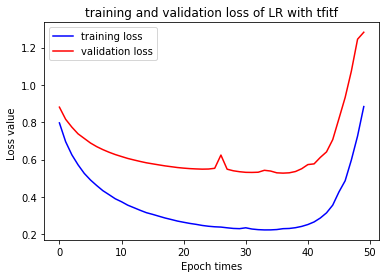

In [34]:
# fill in your code...
plt.plot(range(len(trl)), trl, c = 'blue', label='training loss')
plt.plot(range(len(devl)), devl, c = 'red',label = 'validation loss')
plt.xlabel('Epoch times')
plt.ylabel('Loss value ')
plt.legend()
plt.title('training and validation loss of LR with tfitf')
plt.show()

**Answer:this model is also overfit, because the training loss is lower than the validation loss.**

Compute accuracy, precision, recall and F1-scores:

In [35]:
# fill in your code...
preds_te = predict_class(X_test_tfidf, w_tfidf)
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te))
print('Recall:', recall_score(Y_te,preds_te))
print('F1-Score:', f1_score(Y_te,preds_te))

Accuracy: 0.4925
Precision: 0.4944237918215613
Recall: 0.665
F1-Score: 0.5671641791044776


Print top-10 most positive and negative words:

In [36]:
# fill in your code...
pred_te_tfidf = predict_proba(X_test_tfidf,w_tfidf)
# get index by ascend order 
index = np.argsort(pred_te_tfidf,axis = 0)
print('Top10 positive:1-10')
for i in range(1,11):
    print(X_test_raw[index[-i,0]])

Top10 positive:1-10
susan granger's review of " big eden " ( jour de fete )  it's utopia , this tiny town tucked away in the timberland of northwestern montana , where old codgers lounge on the porch of the general store to pass the time away and the local matchmakers ( nan martin , louise fletcher ) eagerly pair off the young people , regardless of sexual preference .  there's nary a homophobe or bigot around , much to the surprise of henry hart ( arye gross ) , a successful but lonely manhattan artist who returns home to care for sam ( george coe ) , the ailing grandfather who raised him .  and with the simultaneous re-appearance of his best-friend from high-school and object of his unrequited love ( tim dekay ) , now divorced with two young sons , the fact of his homosexuality must be faced .  to complete the triangle , there's the tall , taciturn native american ( eric schweig ) who owns the general store and lovingly yet secretly prepares gourmet meals for henry and sam .  this fa

In [37]:
# fill in your code...
print('Top10 negative: 1 - 10')
for i in range(1,11):
    print(X_test_raw[index[i-1,0]])


Top10 negative: 1 - 10
note : some may consider portions of the following text to be spoilers .  be forewarned .   " quick , robin !  the anti-shark repellant ! "  - adam west in the 1966 batman feature film , casually kicking at a pathetic-looking rubber shark attached to his leg  i had never thought that an entry in the modern incarnation of the batman feature film would approach this level of campiness , but in many instances batman and robin nears , and at some point even exceeds this standard .  this is a disasterously bad film , easily the worst in the series to date , and fairly epitomizes a cinematic definition of the word excessive - it's loud , garish , and obnoxious , with pointless , gratuitous action sequences and set pieces which clutter up the screen with elaborate production design to the point of overkill .  batman and robin features the caped crusaders ( george clooney debuting as batman , with chris o'donnell returing as robin ) squaring off against another bevy of c

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

Enter your answer here...
Hyperparameter is usually selected very carefully, such as the learning rate, if the learning rate is too large, then the number of epochs will be reduced, which will lead to underfit, and if the learning rate is too small, then the model running time will increase significantly, the number of times Will increase, and easily lead to overfitting. And regularisation strength can prevent overfitting



## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |0.7741935483870968   |0.84    |0.8057553956834531   |
| BOW-tfidf  |0.7658536585365854   |0.785   |0.7753086419753088   |


# Multi-class Logistic Regression 

Now you need to train a Multiclass Logistic Regression (MLR) Classifier by extending the Binary model you developed above. You will use the MLR model to perform topic classification on the AG news dataset consisting of three classes:

- Class 1: World
- Class 2: Sports
- Class 3: Business

You need to follow the same process as in Task 1 for data processing and feature extraction by reusing the functions you wrote.

In [38]:
# fill in your code...
data_tr = pd.read_csv('./data_topic/train.csv', names=["class","article"])
data_dev = pd.read_csv('./data_topic/dev.csv',  names=["class","article"])
data_te = pd.read_csv('./data_topic/test.csv',  names=["class","article"])

In [39]:
data_tr.head()

,class,article
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [40]:
# fill in your code...
X_tr_raw = []
Y_tr = []
X_dev_raw = []
Y_dev = []
X_test_raw = []
Y_te = []

# add all raw data into list
for i in range(len(data_tr)):
    X_tr_raw.append(data_tr.iat[i, 1])
    Y_tr.append(data_tr.iat[i, 0])
    
for i in range(len(data_dev)):
    X_dev_raw.append(data_dev.iat[i, 1])
    Y_dev.append(data_dev.iat[i, 0])
    
for i in range(len(data_te)):
    X_test_raw.append(data_te.iat[i, 1])
    Y_te.append(data_te.iat[i, 0])

In [41]:
vocab, df, ngram_counts = get_vocab(X_tr_raw, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

[('legg', 'mason', 'tennis'), ('investor', 'reuters'), ('bj', 'wholesale'), ('out', 'had', 'added'), 'getting', 'after', 'join', 'ask', ('region', 'south', 'ossetia'), 'herat', 'virginia', ('target', 'stocks'), ('third', 'round'), ('fell', 'their', 'lowest'), ('fell', 'more'), 'tellers', ('tomas', 'berdych'), 'pettitte', ('world', 'second', 'largest'), ('dream', 'team'), ('satellite', 'operator', 'said'), 'fueled', 'ongoing', ('commission', 'expected', 'declare'), 'wholesale', ('out', 'prospective'), 'payments', ('sunday', 'killing', 'least'), 'drew', 'issues', 'path', 'travel', 'florida', 'climbed', 'president', ('expected', 'declare', 'initial'), ('exporters', 'such', 'toyota'), ('miss', 'season', 'after'), ('third', 'straight'), 'groups', 'rbi', ('financial', 'services'), ('beijing', 'reuters'), ('washington', 'reuters'), ('retailer', 'behind'), 'efforts', ('blue', 'jays'), ('more', 'than', 'doubled'), 'settler', 'income', ('al', 'sadr'), 'really', 'slump', ('government', 'rep

In [42]:
# fill in your code...
word_id = {}
i = 0
for i, w in enumerate(list(vocab)):
    word_id[w] = i
# generate 3 file ngram list    
X_train_ngram = []
X_dev_ngram = []
X_test_ngram = []

for i in X_tr_raw:
    X_train_ngram.append(extract_ngrams(i, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=stop_words, vocab=vocab))
for i in X_dev_raw:
    X_dev_ngram.append(extract_ngrams(i, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=stop_words, vocab=vocab))
for i in X_test_raw:
    X_test_ngram.append(extract_ngrams(i, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=stop_words, vocab=vocab))

    # vectorise 3 list    
X_tr_count = vectorise(X_train_ngram, vocab)
X_dev_count = vectorise(X_dev_ngram, vocab)
X_test_count = vectorise(X_test_ngram, vocab)

In [43]:
idfs = []
for i in list(vocab):
    # set a variable to record occurance times 
    df_count = 0
    # if it occur, variable + 1
    for j in X_train_ngram:
        if i in j:  
            df_count = df_count + 1
    idfs.append(np.log10(X_tr_count.shape[0]/(df_count+1)))
# change to numpy array
idfs = np.array(idfs)

X_tr_tfidf = X_tr_count * idfs
X_dev_tfidf = X_dev_count * idfs
X_test_tfidf = X_test_count * idfs

Now you need to change `SGD` to support multiclass datasets. First you need to develop a `softmax` function. It takes as input:

- `z`: array of real numbers 

and returns:

- `smax`: the softmax of `z`

In [44]:
def softmax(z):
    
    # fill in your code...
    smax = np.exp(z) / np.sum(np.exp(z),1,keepdims=True)
    return smax

Then modify `predict_proba` and `predict_class` functions for the multiclass case:

In [45]:
def predict_proba(X, weights):
    
    # fill in your code...
    preds_proba = softmax(np.matmul(X,weights.T))
    return preds_proba

In [46]:
def predict_class(X, weights):
    
    # fill in your code...
    pre_pro = predict_proba(X, weights)
    preds_class = np.argmax(pre_pro, 1)
    
    return preds_class+1

Toy example and expected functionality of the functions above:

In [47]:
X = np.array([[0.1,0.2],[0.2,0.1],[0.1,-0.2]])
w = np.array([[2,-5],[-5,2]])

In [48]:
predict_proba(X, w)

array([[0.33181223, 0.66818777],
       [0.66818777, 0.33181223],
       [0.89090318, 0.10909682]])

In [49]:
predict_class(X, w)

array([2, 1, 1], dtype=int64)

Now you need to compute the categorical cross entropy loss (extending the binary loss to support multiple classes).

In [50]:
def categorical_loss(X, Y, weights, num_classes=5, alpha=0.00001):    
    # fill in your code...
    l = 0
    log_pb = np.log(predict_proba(X, weights))
    for i in range(X.shape[0]):
        l = l + log_pb[i, Y[i]-1]
    l = l/X.shape[0]
    l = alpha * np.sum(weights**2) - l
    return l
 

Finally you need to modify SGD to support the categorical cross entropy loss:

In [51]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], num_classes=5, lr=0.01, alpha=0.00001, epochs=5, tolerance=0.001, print_progress=True):
    
    # fill in your code...
    training_loss_history = []
    validation_loss_history = []

    weights = np.zeros([num_classes, X_tr.shape[1]])
    for i in range(epochs):
        #  generate random order of Dtrain
        ran_order = np.random.permutation(X_tr.shape[0])
        for j in ran_order:
            Z_tr = predict_proba(X_tr[j:j+1,:], weights)
            Z_tr[0, Y_tr[j]-1] -= 1
            weights -=  lr * ( Z_tr.T * X_tr[j:j+1,:] + 2*alpha*weights)

        # append every loss results into training and validation loss
        training_loss_history.append(categorical_loss(X_tr, Y_tr, weights, alpha))
        validation_loss_history.append(categorical_loss(X_dev, Y_dev, weights, alpha))

        if print_progress:
            print('Epoch times: {}, Training loss value: {}, Validation loss: {}'.format(i, training_loss_history[-1], validation_loss_history[-1]))
        if len(validation_loss_history)>=2 and np.abs(validation_loss_history[-1] - validation_loss_history[-2]) < tolerance:
            break

    return weights, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you MLR following the same steps as in Task 1 for both Count and tfidf features:

In [52]:
w_count, loss_tr_count, dev_loss_count = SGD(X_tr_count, Y_tr, 
                                             X_dev=X_dev_count, 
                                             Y_dev=Y_dev,
                                             num_classes=3,
                                             lr=0.0001, 
                                             alpha=0.001, 
                                             epochs=200)

Epoch times: 0, Training loss value: 1.0686911723934174, Validation loss: 1.0832890395793449
Epoch times: 1, Training loss value: 1.0422035734856754, Validation loss: 1.069052794469893
Epoch times: 2, Training loss value: 1.0184803565879992, Validation loss: 1.055723890777719
Epoch times: 3, Training loss value: 0.9969193936579083, Validation loss: 1.0431425566109558
Epoch times: 4, Training loss value: 0.9771059624388269, Validation loss: 1.031201926682416
Epoch times: 5, Training loss value: 0.9587300524933496, Validation loss: 1.0198101791392435
Epoch times: 6, Training loss value: 0.9415627654452706, Validation loss: 1.008901398091886
Epoch times: 7, Training loss value: 0.925445251907974, Validation loss: 0.9984228951750879
Epoch times: 8, Training loss value: 0.9102507963825065, Validation loss: 0.9883422691461466
Epoch times: 9, Training loss value: 0.8958815880622502, Validation loss: 0.9786220761981399
Epoch times: 10, Training loss value: 0.8822551254168536, Validation loss: 

Epoch times: 88, Training loss value: 0.5035970406055972, Validation loss: 0.6490660700458125
Epoch times: 89, Training loss value: 0.5016190578313815, Validation loss: 0.6471872107242357
Epoch times: 90, Training loss value: 0.4996670233161364, Validation loss: 0.6453328226891957
Epoch times: 91, Training loss value: 0.49774053433330967, Validation loss: 0.6435023696342286
Epoch times: 92, Training loss value: 0.49583901413700815, Validation loss: 0.6416958401522727
Epoch times: 93, Training loss value: 0.4939615150848979, Validation loss: 0.6399118429183579
Epoch times: 94, Training loss value: 0.4921079178151777, Validation loss: 0.6381503814533998
Epoch times: 95, Training loss value: 0.4902777623791359, Validation loss: 0.6364111255286816
Epoch times: 96, Training loss value: 0.48847022033664794, Validation loss: 0.6346934274926417
Epoch times: 97, Training loss value: 0.486684972656647, Validation loss: 0.6329963794658979
Epoch times: 98, Training loss value: 0.48492139396583966,

Plot training and validation process and explain if your model overfit, underfit or is about right:

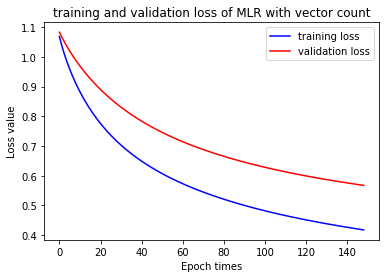

In [53]:
# fill in your code...
plt.plot(range(len(loss_tr_count)), loss_tr_count, c = 'blue', label='training loss')
plt.plot(range(len(dev_loss_count)), dev_loss_count,c= 'red', label = 'validation loss', )
plt.xlabel('Epoch times')
plt.ylabel('Loss value')
plt.legend()
plt.title('training and validation loss of MLR with vector count')
plt.show()

Answer:this model is also overfit, because the training loss is lower than the validation loss.

Compute accuracy, precision, recall and F1-scores:

In [54]:
# fill in your code...

preds_te = predict_class(X_test_count, w_count)
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8522222222222222
Precision: 0.8545592790763165
Recall: 0.8522222222222222
F1-Score: 0.8514022251643323


Print the top-10 words for each class respectively.

In [55]:
# fill in your code...

classes = ['1', '2', '3']
preds_test_count = predict_proba(X_test_count, w_count)

for i, j in enumerate(classes):
    print(j)
    loc = np.argsort(preds_test_count[:,i])
    for i in range(10):
        print('Top10 ',i+1, X_test_raw[loc[-1-i]])

1
Top10  1 NAJAF, Iraq - Iraq's most powerful Shiite cleric returned home from Britain on Wednesday to help broker an end to nearly three weeks of fighting in Najaf and is calling on his followers to join him in a march to reclaim the holy city, his spokesmen and witnesses said.    Grand Ayatollah Ali Husseini al-Sistani return came as heavy fighting persisted in Najaf's Old City...
Top10  2 BAGHDAD, Iraq - Rebel Shiite cleric Muqtada al-Sadr called for his followers across Iraq to end fighting against U.S. and Iraqi forces and is planning to join the political process in the coming days, an al-Sadr aide said Monday...
Top10  3 NAJAF, Iraq - Militants loyal to radical Shiite cleric Muqtada al-Sadr kept their hold on a revered shrine, and clashes flared in Najaf on Saturday, raising fears that a resolution to the crisis in the holy city could collapse amid bickering between Shiite leaders.    The clashes between U.S...
Top10  4 BAGHDAD, Iraq - Delegates at Iraq's National Conference cal

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

Hyperparameter is usually selected very carefully, such as the learning rate, if the learning rate is too large, then the number of epochs will be reduced, which will lead to underfit, and if the learning rate is too small, then the model running time will increase significantly, the number of times Will increase, and easily lead to overfitting. And regularisation strength can prevent overfitting

### Now evaluate BOW-tfidf...

In [56]:
w_tfidf, trl, devl = SGD(X_tr_tfidf, Y_tr, 
                         X_dev=X_dev_tfidf, 
                         Y_dev=Y_dev, 
                         lr=0.0001, 
                         alpha=0.001, 
                         epochs=200)

Epoch times: 0, Training loss value: 1.4999092063034818, Validation loss: 1.5434016413390403
Epoch times: 1, Training loss value: 1.407915390305509, Validation loss: 1.4842549825882112
Epoch times: 2, Training loss value: 1.3289855538609154, Validation loss: 1.430841683674241
Epoch times: 3, Training loss value: 1.2597672788385388, Validation loss: 1.3821813732710295
Epoch times: 4, Training loss value: 1.1983043592892662, Validation loss: 1.3375757170599305
Epoch times: 5, Training loss value: 1.1433543600325324, Validation loss: 1.2965669466810905
Epoch times: 6, Training loss value: 1.0939411745771432, Validation loss: 1.258731305284789
Epoch times: 7, Training loss value: 1.0493390764071575, Validation loss: 1.2237643777197835
Epoch times: 8, Training loss value: 1.0088688292211838, Validation loss: 1.191335719087575
Epoch times: 9, Training loss value: 0.9720292648799856, Validation loss: 1.1612182279390817
Epoch times: 10, Training loss value: 0.9383503236564024, Validation loss:

Epoch times: 88, Training loss value: 0.3396965147924415, Validation loss: 0.5554665732532008
Epoch times: 89, Training loss value: 0.3376125901637595, Validation loss: 0.5533376994364424
Epoch times: 90, Training loss value: 0.3355624768402945, Validation loss: 0.5512465163954902
Epoch times: 91, Training loss value: 0.3335453131132228, Validation loss: 0.5491869215200512
Epoch times: 92, Training loss value: 0.3315601484571504, Validation loss: 0.5471598188499794
Epoch times: 93, Training loss value: 0.3296062344783096, Validation loss: 0.5451674521043234
Epoch times: 94, Training loss value: 0.32768282422689177, Validation loss: 0.5432083708479735
Epoch times: 95, Training loss value: 0.32578891062364335, Validation loss: 0.5412809290376607
Epoch times: 96, Training loss value: 0.3239239401434832, Validation loss: 0.5393832755680152
Epoch times: 97, Training loss value: 0.3220872499115826, Validation loss: 0.5375149015505781
Epoch times: 98, Training loss value: 0.3202779922655868, 

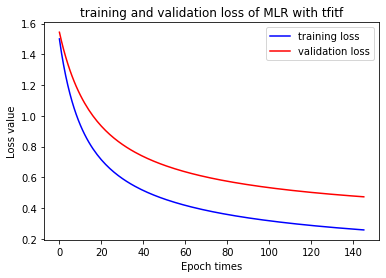

In [57]:
plt.plot(range(len(trl)), trl, c = 'blue', label='training loss')
plt.plot(range(len(devl)), devl,c = 'red', label = 'validation loss' )
plt.xlabel('Epoch times')
plt.ylabel('Loss value')
plt.legend()
plt.title('training and validation loss of MLR with tfitf')
plt.show()

this model is also overfit, because the training loss is lower than the validation loss

In [58]:
preds_te = predict_class(X_test_tfidf, w_tfidf)
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.88
Precision: 0.881547680555811
Recall: 0.8799999999999999
F1-Score: 0.8793734034496704


In [59]:
classes = ['1', '2', '3']
pred_test_tfidf = predict_proba(X_test_tfidf, w_tfidf)

for i, j in enumerate(classes):
    print(j)
    loc = np.argsort(pred_test_tfidf[:,i])
    for i in range(10):
        print('Top10 ',i+1, X_test_raw[loc[-1-i]])

1
Top10  1 NAJAF, Iraq - Iraq's most powerful Shiite cleric returned home from Britain on Wednesday to help broker an end to nearly three weeks of fighting in Najaf and is calling on his followers to join him in a march to reclaim the holy city, his spokesmen and witnesses said.    Grand Ayatollah Ali Husseini al-Sistani return came as heavy fighting persisted in Najaf's Old City...
Top10  2 BAGHDAD, Iraq - Rebel Shiite cleric Muqtada al-Sadr called for his followers across Iraq to end fighting against U.S. and Iraqi forces and is planning to join the political process in the coming days, an al-Sadr aide said Monday...
Top10  3 NAJAF, Iraq - Militants loyal to radical Shiite cleric Muqtada al-Sadr kept their hold on a revered shrine, and clashes flared in Najaf on Saturday, raising fears that a resolution to the crisis in the holy city could collapse amid bickering between Shiite leaders.    The clashes between U.S...
Top10  4 BAGHDAD, Iraq - Delegates at Iraq's National Conference cal

## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |0.8545592790763165   |0.8522222222222222   |0.8514022251643323   |
| BOW-tfidf  |0.881547680555811   |0.8799999999999999   |0.8793734034496704   |
